# Import Packages, Grab Data via Script

In [1]:
!pip install pybaseball
!pip install ipympl
%pip install unidecode
import unidecode
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
%run plot_funcs.py
%run data.py
%matplotlib widget

from google.colab import output
output.enable_custom_widget_manager()

In [8]:
# Creates cheat-sheet of  pitches and corresponding value after being encoded
outcomes = pd.DataFrame()
outcomes['Hit Type'] = label_encoder.inverse_transform(list(set(y)))
outcomes['Encoded'] = list(set(y))

print(outcomes)

  Hit Type  Encoded
0   double        0
1   single        1
2   triple        2


# Model Instantiation, Comparison

## Building Models

In [11]:
# Define the column transformer for different scalers
minmax_features = ['game_week', 'launch_speed', 'angle']
standardscale_features = ['launch_angle', 'distance','sprint_speed']
categorical_features = ['home_team']

preprocessor = ColumnTransformer(
    transformers=[
        ('standard_scale', StandardScaler(), standardscale_features),           # Use StandardScaler for numeric features
        ('minmax', MinMaxScaler(), minmax_features),              # Use MinMaxScaler for numeric features
        ('categorical', OneHotEncoder(sparse=False), categorical_features)     # Use OneHotEncoder for categorical features
    ])

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=69)

In [17]:
# Define RandomForest parameters
param_grid = {
    'n_estimators': [50,100,200],
    'criterion': ['gini','entropy'],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
}

# Define Balanced Random Forests and Weighted Random Forests
b_rf = BalancedRandomForestClassifier(n_jobs = -1, sampling_strategy = 'not minority')
w_rf_ba = RandomForestClassifier(n_jobs = -1, class_weight = 'balanced')


# Define the classifiers
classifiers = [
    ('Balanced RandomForest', b_rf),
    ('Weighted RandomForest (Balanced)', w_rf_ba),
]

# Define the metrics
metrics = {
    'Precision': precision_score,
    'Recall': recall_score,
    'F1-Score': f1_score,
    'ROC-AUC': roc_auc_score,
    "Cohen's Kappa": cohen_kappa_score,
    'Recall, double': None,
    'Recall, single': None,
    'Recall, triple': None
}

Evaluating... Balanced RandomForest


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The functi

Evaluating... Weighted RandomForest (Balanced)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


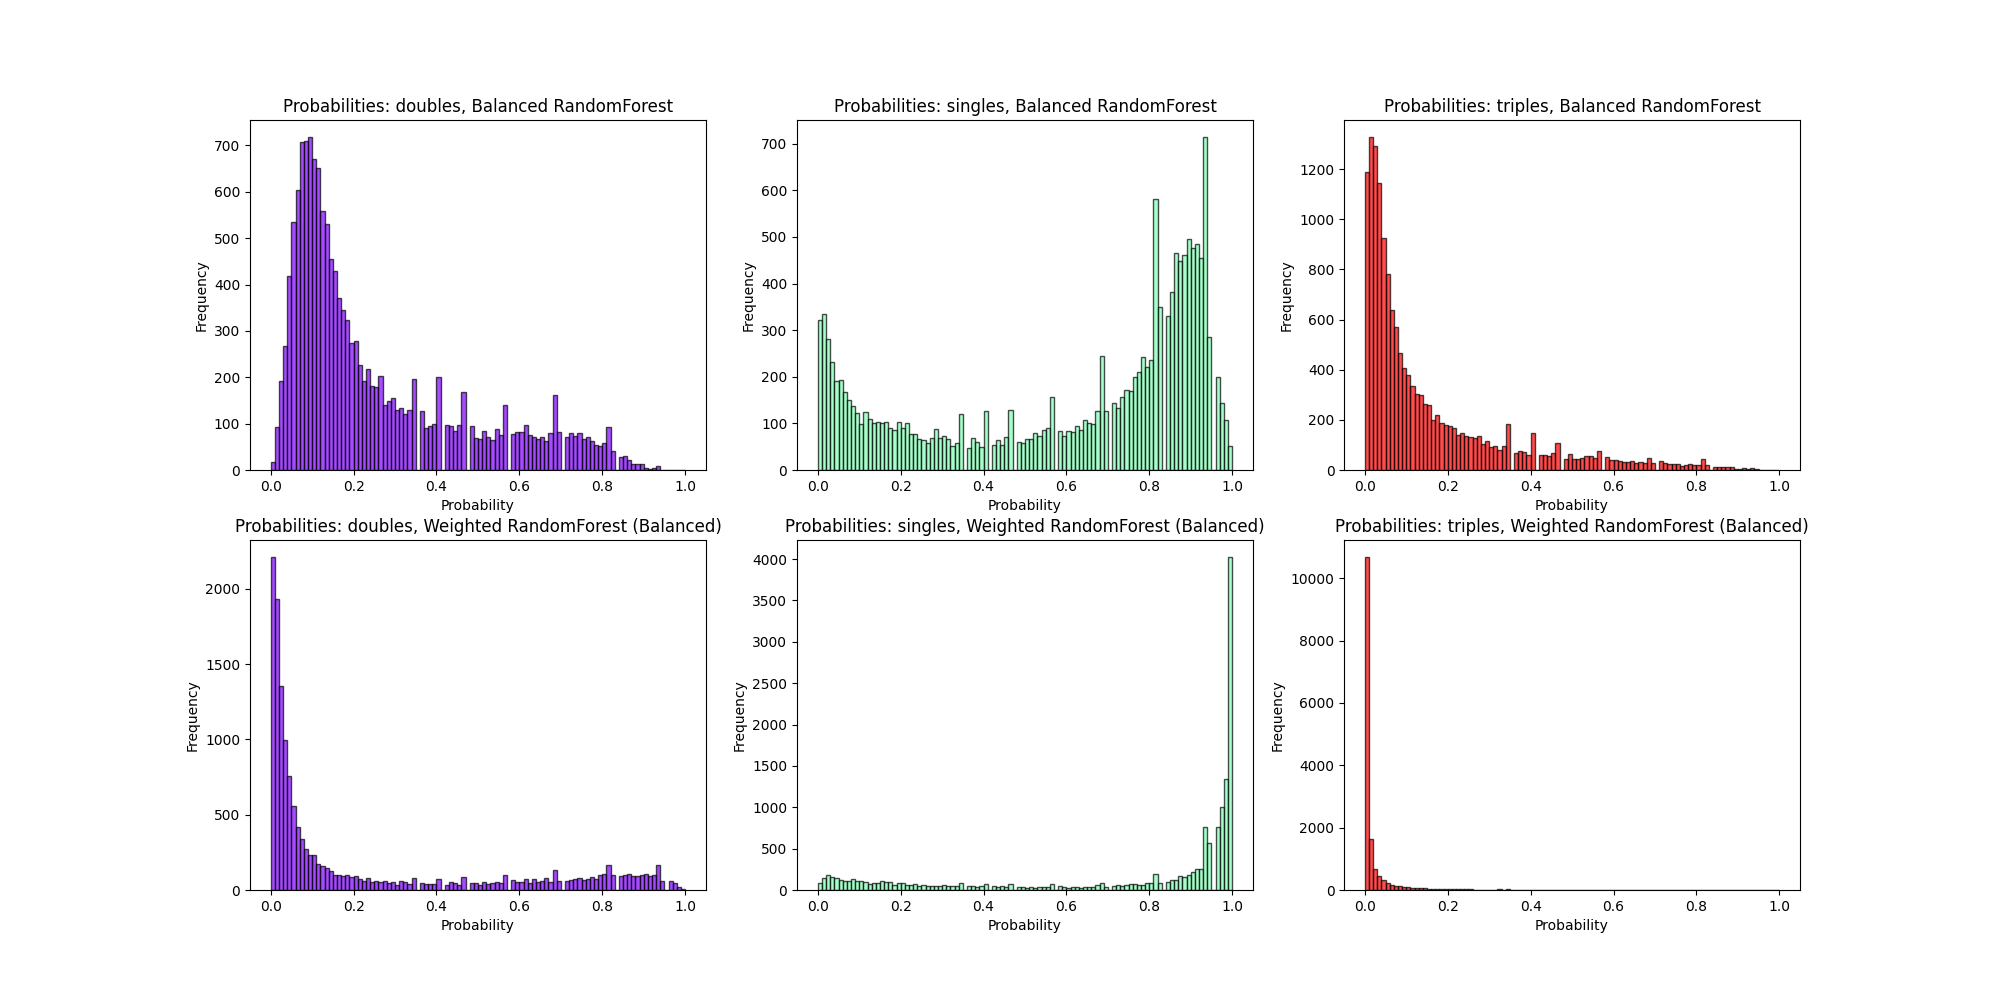

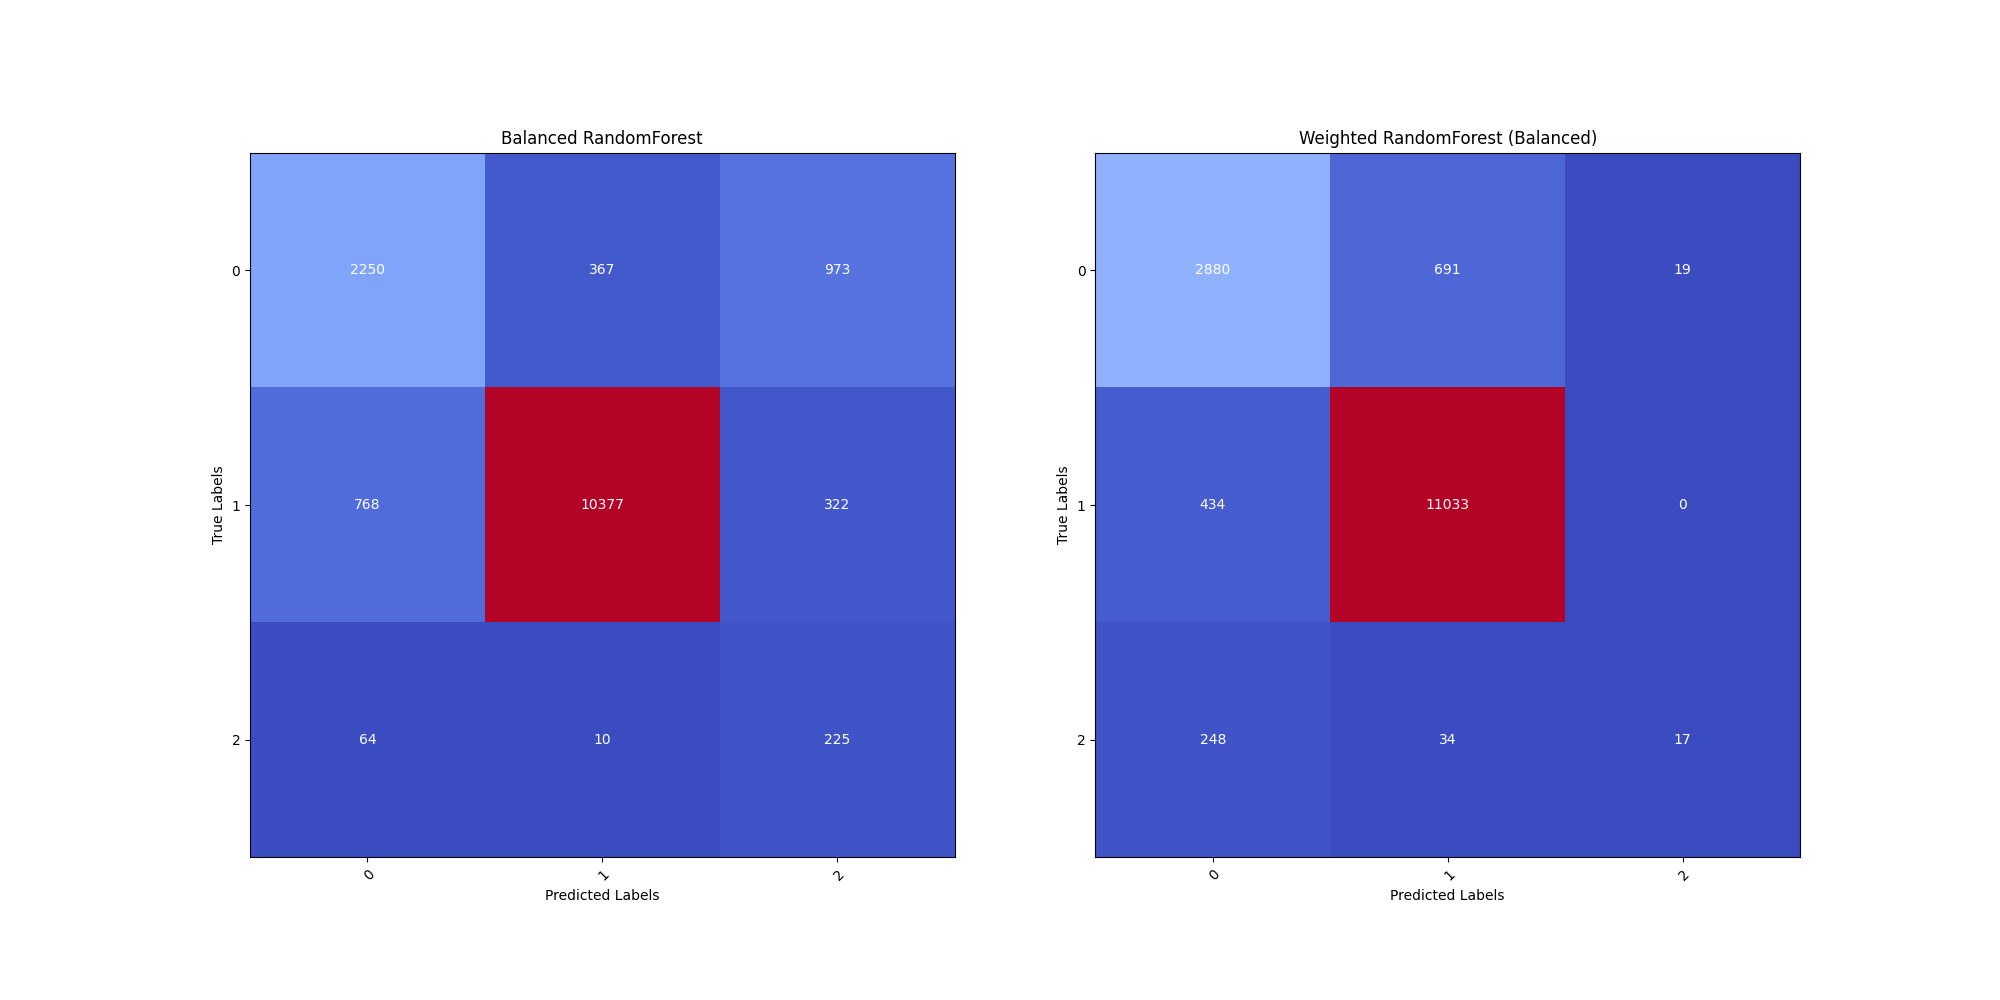

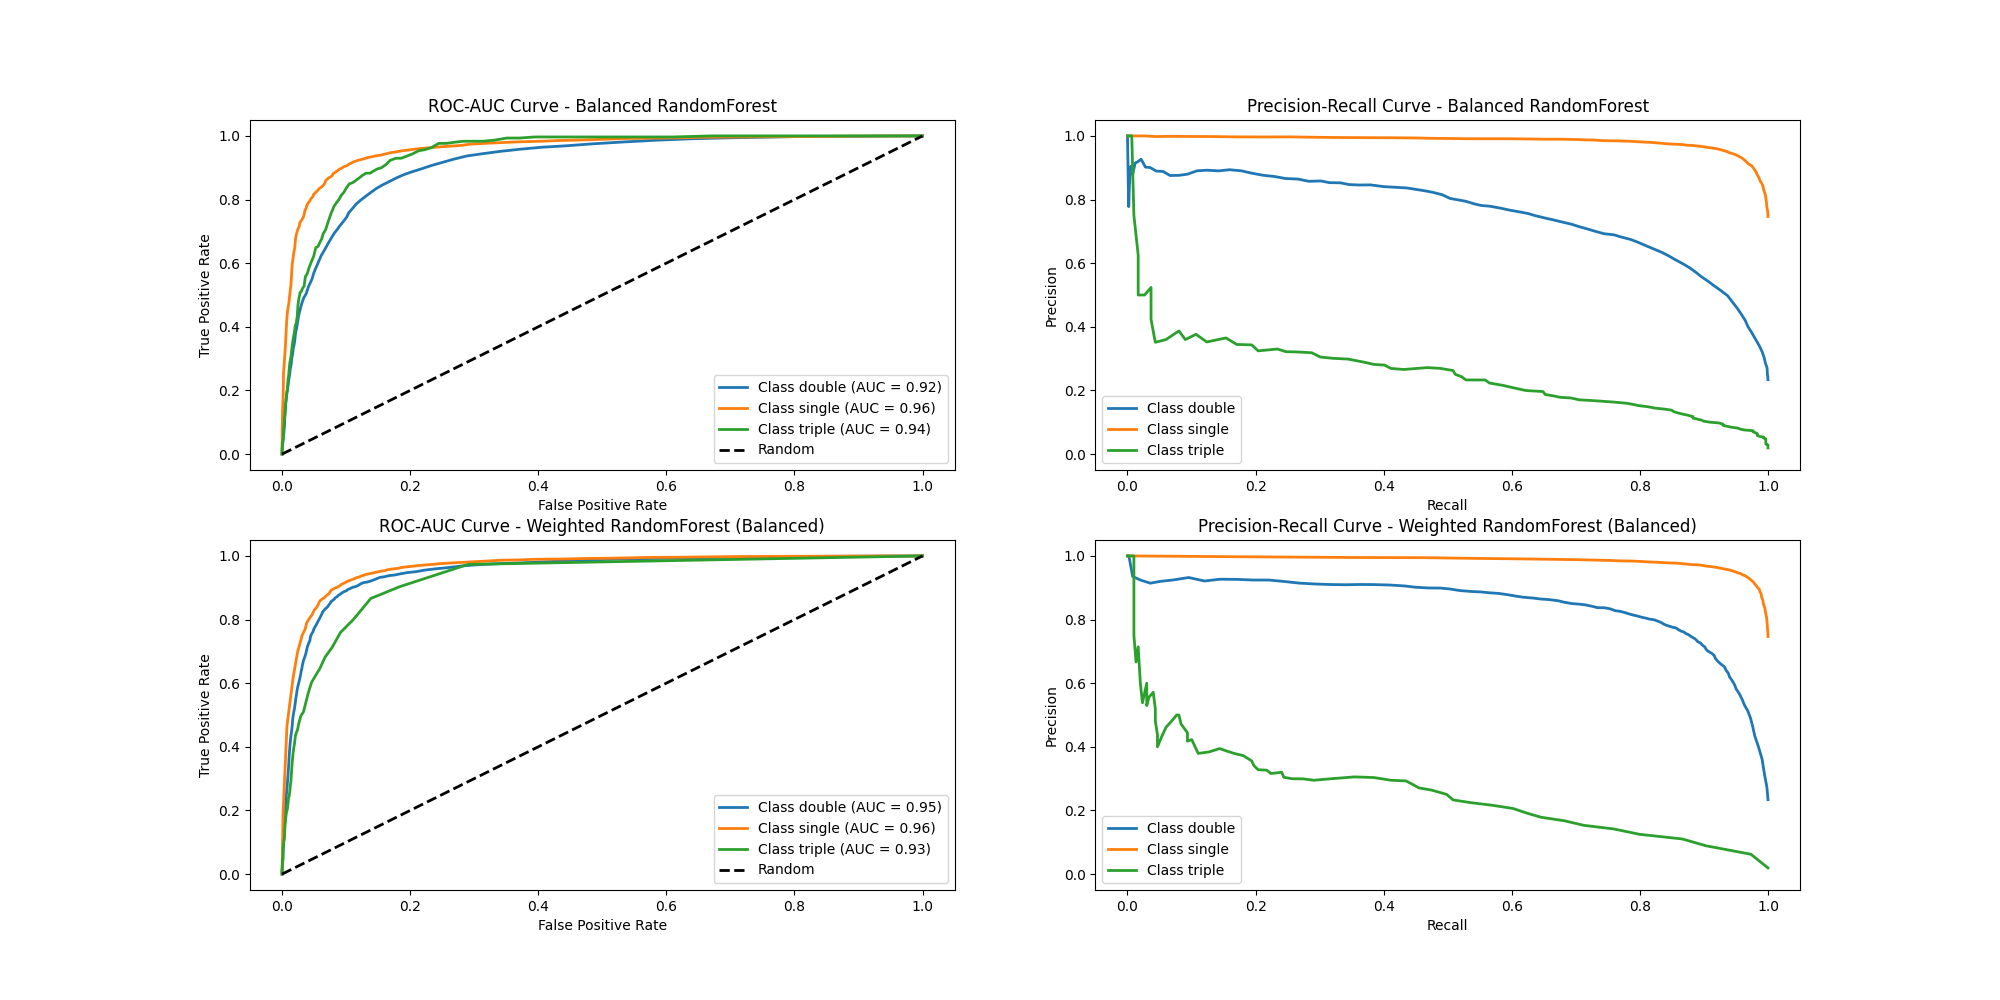

In [19]:
# Create an empty DataFrame to store the metrics
results_df = pd.DataFrame(columns=list(metrics.keys()))

classes = np.unique(y_train)
num_classifiers = len(classifiers)

# Create a figure to hold the confusion matrices and ROC-AUC, Precision-Recall Curves
fig, axes = plt.subplots(nrows= num_classifiers, ncols=3, figsize=(20, 5 * num_classifiers))
fig2, axes2 = plt.subplots(nrows=1, ncols=len(classifiers), figsize=(20, 5 * num_classifiers))
fig3, axes3 = plt.subplots(nrows= num_classifiers, ncols=2, figsize=(20, 5 * num_classifiers))

fitted_models = []

# Iterate over classifiers
for z, (name, classifier) in enumerate(classifiers):
    print('Evaluating...', name)


    # Create the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('random search', RandomizedSearchCV(estimator=classifier, param_distributions=param_grid,
                                   n_iter=10, scoring='roc_auc_ovr_weighted', cv=10, random_state=69))
        ])

    # Train the pipeline
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)


    # Plot Probability Distribution For Each Class For Each Classifier
    ax_prob = axes
    plot_probability_histograms(name, y_pred_proba, ax_prob, z, label_encoder)


    # Calculate and store the metrics for the classifier
    results = {key: None for key in metrics.keys()}

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)


    # Iterate over the list and find the index of the tuple containing the model name
    ax_index = None
    for i, item in enumerate(classifiers):
        if name in item:
            ax_index = i
            break

    # Plot confusion matrix
    ax_cm = axes2[ax_index]
    plot_confusion_matrix(cm, ax_cm, name, classes)


    # Define each row of matplotlib figure, plot ROC-AUC and Precision-Recall
    ax_rocauc = axes3[z, 0]
    ax_pr = axes3[z, 1]

    plot_rocauc_pr_rec(name, ax_rocauc, ax_pr, y_test, y_pred_proba, classes, label_encoder)

    # Add all metrics to dictionary, add to DataFrame
    for metric_name, metric_func in metrics.items():
        if metric_name in ['Precision', 'Recall', 'F1-Score']:
            metric_value = metric_func(y_test, y_pred, average='weighted')
        elif metric_name == 'ROC-AUC':
          metric_value = metric_func(y_test, y_pred_proba, average = 'weighted', multi_class = 'ovr')
        elif metric_name == "Cohen's Kappa":
          metric_value = metric_func(y_test, y_pred)

        results[metric_name] = metric_value

    # Get classification report
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract precision values from the report
    class_names = list(report.keys())
    class_names.remove('accuracy') # Remove 'accuracy' from class names
    class_names.remove('macro avg') # Remove 'macro avg' from class names
    class_names.remove('weighted avg') # Remove 'weighted avg' from class names

    for class_name in class_names:
      results[f'Recall, {label_encoder.inverse_transform([int(class_name)])[0]}'] = report[class_name]['recall']

    #print(results)

    # Add the results to the DataFrame
    results_df.loc[name] = pd.Series(results)

    # Add pipeline to list
    fitted_models.append((name, pipeline))

In [20]:
# Print the results
results_df

,Precision,Recall,F1-Score,ROC-AUC,Cohen's Kappa,"Recall, double","Recall, single","Recall, triple"
Balanced RandomForest,0.894121,0.836937,0.859941,0.949276,0.619186,0.626741,0.904945,0.752508
Weighted RandomForest (Balanced),0.898917,0.907137,0.899738,0.960919,0.751669,0.802228,0.962152,0.056856


In [21]:
fitted_models

[('Balanced RandomForest',
  Pipeline(steps=[('preprocessor',
                   ColumnTransformer(transformers=[('standard_scale',
                                                    StandardScaler(),
                                                    ['launch_angle', 'distance',
                                                     'sprint_speed']),
                                                   ('minmax', MinMaxScaler(),
                                                    ['game_week', 'launch_speed',
                                                     'angle']),
                                                   ('categorical',
                                                    OneHotEncoder(sparse=False),
                                                    ['home_team'])])),
                  ('random search',
                   RandomizedSearchCV(cv=10,
                                      estimator=BalancedRandomForestClassifier(n_jobs=-1,
                                

# Evaluate on Corbin Carroll, Real ISO 2022: .240

In [163]:
# Get Fangraphs data, add first and last name columns, decode names
fg_data = pybaseball.batting_stats(2022, qual = 1)[['Name','AB','HR','ISO']]
fg_data['last_name'] = fg_data.apply(lambda x: (unidecode.unidecode(x['Name'])).lower().split(' ')[1], axis = 1)
fg_data['first_name'] = fg_data.apply(lambda x: (unidecode.unidecode(x['Name'])).lower().split(' ')[0], axis = 1)
fg_data = fg_data[['last_name','first_name','AB','HR','ISO']]

In [164]:
fg_data

,last_name,first_name,AB,HR,ISO
6,judge,aaron,570,62,0.375
23,machado,manny,578,32,0.234
26,arenado,nolan,557,30,0.241
13,goldschmidt,paul,561,35,0.260
21,freeman,freddie,612,21,0.186
...,...,...,...,...,...
575,tsutsugo,yoshi,170,2,0.059
372,diaz,elias,351,9,0.140
633,cano,robinson,100,1,0.040
417,cabrera,miguel,397,5,0.063


In [165]:
carroll_ISO = fg_data[(fg_data['last_name'] == 'carroll') & (fg_data['first_name'] == 'corbin')]['ISO'].values[0]
carroll_ABs = fg_data[(fg_data['last_name'] == 'carroll') & (fg_data['first_name'] == 'corbin')]['AB'].values[0]
carroll_HRs = fg_data[(fg_data['last_name'] == 'carroll') & (fg_data['first_name'] == 'corbin')]['HR'].values[0]
carroll_ISO, carroll_ABs, carroll_HRs

(0.24, 104, 4)

In [166]:
# Statcast lookup,

carroll_id = pybaseball.playerid_lookup('carroll','corbin')['key_mlbam'][0]
carroll_data = pybaseball.statcast_batter('2022-08-29', '2022-10-03', player_id = carroll_id)

Gathering Player Data


In [167]:
iterations = 100

b_rf_df = pd.DataFrame(columns=['doubles','triples','home_runs','pp_ISO'])
w_rf_df = pd.DataFrame(columns=['doubles','triples','home_runs','pp_ISO'])

# Clean Data, get different samplings of sprint speed as well, perform this many times via for loop and save dataframes
b_rf_model = fitted_models[0][1]
w_rf_model = fitted_models[1][1]

carroll_data_li = []
# For number of iterations, clean data and get new sprint speed values
for i in range(iterations):
  carroll_X, carroll_y, label_encoder = clean_data(carroll_data, speed_data)
  carroll_data_li.append((carroll_X, carroll_y))

# Do another for loop, predict on data and calculate ISO
for i in carroll_data_li:
  # define metrics to save to dataframe
  b_rf_res = {'doubles': None, 'triples': None,'home_runs': carroll_HRs, 'pp_ISO': None}
  w_rf_res = {'doubles': None, 'triples': None,'home_runs': carroll_HRs, 'pp_ISO': None}

  # Predict on Balanced Forest, save metrics
  b_rf_pred = b_rf_model.predict(i[0])
  b_rf_res['doubles'] = np.count_nonzero(b_rf_pred == 0)
  b_rf_res['triples'] = np.count_nonzero(b_rf_pred == 2)
  b_rf_res['pp_ISO'] = round((b_rf_res['doubles'] + 2*b_rf_res['triples'] + 3*b_rf_res['home_runs']) / carroll_ABs, 3)
  b_rf_df = b_rf_df.append(b_rf_res, ignore_index=True)

  # Predict on Weighted Forest, save metrics
  w_rf_pred = w_rf_model.predict(i[0])
  w_rf_res['doubles'] = np.count_nonzero(w_rf_pred == 0)
  w_rf_res['triples'] = np.count_nonzero(w_rf_pred == 2)
  w_rf_res['pp_ISO'] = round((w_rf_res['doubles'] + 2*w_rf_res['triples'] + 3*w_rf_res['home_runs']) / carroll_ABs, 3)
  w_rf_df = w_rf_df.append(w_rf_res, ignore_index=True)

/content/data.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hits['game_date'] = pd.to_datetime(hits['game_date'])
/content/data.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hits['game_date'] = hits.apply(lambda x: (x['game_date'].date() - season_start).days // 7, axis = 1)
/content/data.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [168]:
# Performance on 2022 Corbin Carroll data: Balanced Random Forest (prone to overpredicting triples)
print('Balanced RandomForest predicted ISO (Corbin Carroll 2022):', round(b_rf_df['pp_ISO'].mean(), 3))

Balanced RandomForest predicted ISO (Corbin Carroll 2022): 0.287


In [169]:
# Performance on 2022 Corbin Carroll data: Weighted Random Forest (prone to undderpredicting triples)
print('Balanced RandomForest predicted ISO (Corbin Carroll 2022):', round(w_rf_df['pp_ISO'].mean(), 3))

Balanced RandomForest predicted ISO (Corbin Carroll 2022): 0.192
